# model.ipynb: 示例代码，建立两个决策树
这是示例代码，目的是为了让您更好地了解我们的算法。

方便起见，本notebook中只用了一个训练集，即`final-2.h5`。如果要使用全部的训练集，请参见`train.ipynb`。

为了能够更加清晰地展现出数据的处理过程，这里不用先跑预处理数据的代码`waveform.py`，而会将对数据的预处理放在代码块中。

本notebook的任务是训练出两个决策树：第一个的目标是每个waveform对应的PE数，即`modelPePerWF.txt`；第二个的目标是每个事件的动量p，即`modelP.txt`。

训练完之后，运行`final.ipynb`，便可以得到最终的答案。

In [1]:
import multiprocessing
import warnings # 临时需要，没有的话有一步代码会疯狂爆mean一个空数组的warning，其实这是正常情况
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from utils import loadData, getNum, getPePerWF, saveData, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包

指定__训练集__的位置。git仓库中并没有data这个文件夹，需要手动创建，并将数据集下载到该目录下。\
这一步可能需要一分钟左右。结束后会展示读进来的三个表的信息。

In [2]:
trainPath = "./data/final-2.h5" # 指定训练集位置

# trainPET是PETruth表，trainWF是Waveform表，trainPT是ParticleTruth表
trainPET, trainWF, trainPT = loadData(trainPath, 'PT')

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


为了训练第二个决策树，我们需要将属于一个Event的PE或Waveform分开。

这里调用了`utils.py`中定义的`getNum`函数。得到的`peIndices`是一个$(n+1,)$的ndarray，$n$表示训练集的EventID数。当$i<n$时，`peIndices[i]`表示EventID为$i$对应第一个PE或Waveform的index；当$i=n$时，`peIndices[i]`表示训练集的总行数。`wfIndices`是类似的。

为什么要$n+1$呢？~历史上是因为这样能更方便地得到`numPET`~因为如果需要将18个训练集拼接成一个训练集，就会方便很多。详见`train.ipynb`。

`numPET`和`numPEW`都是$(n,)$的ndarray，下标为$i$各表示EventID为$i$时的PE数和波形数。这两个变量后面并没有用到，因为历史原因保留在这里。

In [6]:
numPET, peIndices = getNum(trainPET)
numPEW, wfIndices = getNum(trainWF)

为了训练，需要得到每个waveform对应的pe数`pePerTrainWF`，作为真值。

In [7]:
pePerTrainWF = np.array([], dtype=int)
splitWFChannels = np.split(trainWF['ChannelID'], wfIndices[1:-1])
for index, arr in enumerate(tqdm(np.split(trainPET['ChannelID'], peIndices[1:-1]))):
    channels, counts = np.unique(arr, return_counts=True)
    
    # 上面得到的counts并不能直接用，因为需要为暗触发的waveform补0

    # 使用isin得到counts虽然很简洁，但似乎略慢于傻傻地使用while，原因不明。
    # indicesToInsert = np.isin(splitWFChannels[index], channels, invert=True).nonzero()[0]
    # for indexToInsert in indicesToInsert:
        # counts = np.insert(counts, indexToInsert, 0) #注意不能一次性insert了，要用for循环，因为可能会越界访问。

    zeroPeChannelCount = numPEW[index].astype(int) - channels.shape[0]
    while zeroPeChannelCount:
        alignedChannels = np.append(channels, np.zeros(zeroPeChannelCount)-1)
        indexToInsert = np.asarray(alignedChannels != splitWFChannels[index]).nonzero()[0][0]
        channels = np.insert(channels, indexToInsert, splitWFChannels[index][indexToInsert])
        counts = np.insert(counts, indexToInsert, 0)
        zeroPeChannelCount -= 1
    
    pePerTrainWF = np.append(pePerTrainWF, counts)

pePerTrainWF = pePerTrainWF.flatten().astype(int)
# peTimesPerTrainWF = np.split(trainPET['PETime'], np.cumsum(pePerTrainWF))[:-1]

100%|██████████| 2000/2000 [00:21<00:00, 94.78it/s] 


去除`TrainWF`的噪声：设置下限为918，小于918的认为是有意义的信息，大于等于918的认为是噪声。

为什么是918？这是我盯着一大堆waveform看出来的经验常数（误）

In [3]:
denoisedTrainWF = np.where(trainWF['Waveform'] < 918, 918-trainWF['Waveform'], 0)

对于denoisedTrainWF数据，取出三个feature，目的是找到每个波形对应多少个PE。
1. 波形的积分`intTrainWF`
2. 超出阈值的波形点数`pointsPerTrainWF`
3. 手动处理，得到的每个波形对应的PE`pePerTrainWFCalc`

除此之外，用手动方式得到每个波形对应的PETime的平均值`meanPeTimePerTrainWF`，以后需要用到。

In [4]:
intTrainWF = np.sum(denoisedTrainWF, axis=1)
pointsPerTrainWF = np.sum(denoisedTrainWF > 0, axis=1)

简单介绍一下手作算法：
1. 对一个波形，反复`np.argmax`，找到最大值对应的index后，认为这是一次PE所在的位置；
2. 将波形减去一个峰值在argmax处的取消函数（表示一个PE产生的效果）；
3. 在取消函数不为0的区域，判断纵坐标是否小于一个特定的值，如果是则认为是噪声，置为0；
4. 重复1-3的操作，直到波形的积分小于某个特定值，或者超过0的点小于某个特定值为止；
5. 最后得到一个`wfArgmax`数组，对这个数组，取长度`PePerTrainWFCalc`与去除部分暗噪声（argmax小于特定值或大于特定值）的平均值减去一个常数14.5(还是经验常数，差不多等于PETime)`meanPeTimePerTrainWF`，作为返回值。

实际使用的手作算法略复杂于上面的描述，详见`utils.py`中定义的`getPePerWF`。

这里有很多参数可以调，可以使用以下的代码观察当前手作算法的效果。

PE真值是4
积分是565
超出阈值的点是51
结果是(4, 340.25)


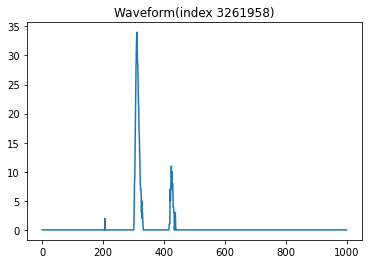

In [179]:
randIndex = np.random.randint(0, denoisedTrainWF.shape[0]-1) # 随机取一个波形
# randIndex = 4197077
# randIndex = 3803407
# randIndex = 5620201
# randIndex = 1132892
res = getPePerWF(denoisedTrainWF[randIndex])
print(f"PE真值是{pePerTrainWF[randIndex]}")
print(f"积分是{intTrainWF[randIndex]}")
print(f"超出阈值的点是{pointsPerTrainWF[randIndex]}")
print(f"结果是{res}")
plt.plot(denoisedTrainWF[randIndex])
plt.title(f"Waveform(index {randIndex})")
plt.show()

这是正式处理训练集的代码。手作算法比较慢，取决于计算机速度，可能会花费20分钟左右。

注意，如果没有`warnings.simplefilter("ignore")`，会导致疯狂爆mean一个空数组的warning。这是由于一个waveform可能全是暗噪声，或者根本就是暗触发，导致手作算法根本没有运行argmax（这也是正确的表现）。后面的代码会处理nan，所以这里忽略warning。

In [180]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with multiprocessing.Pool(8) as p: # 开了八个进程，视cpu情况，可以将8改为适合当前cpu的值
        res = np.array(
            list(tqdm(
                p.imap(
                    getPePerWF,
                    denoisedTrainWF
                ), total=denoisedTrainWF.shape[0]
            ))
        )

pePerTrainWFCalc = res[:, 0]
meanPeTimePerTrainWF = res[:, 1]

100%|██████████| 6041164/6041164 [16:08<00:00, 6237.57it/s]


下面检验三个feature对于真正的`pePerTrainWF`的关系，画出三个散点图：

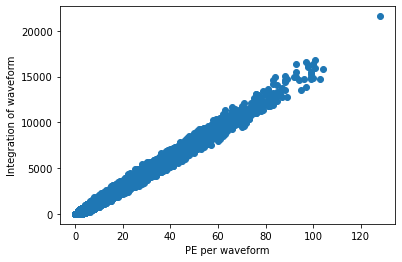

In [55]:
plt.scatter(pePerTrainWF, intTrainWF)
plt.xlabel("PE per waveform")
plt.ylabel("Integration of waveform")
plt.show()

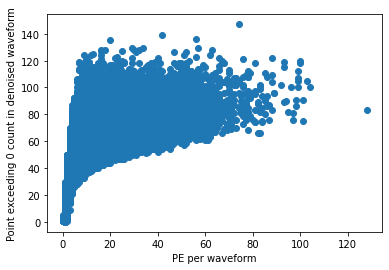

In [56]:
plt.scatter(pePerTrainWF, pointsPerTrainWF)
plt.xlabel("PE per waveform")
plt.ylabel("Point exceeding 0 count in denoised waveform")
plt.show()

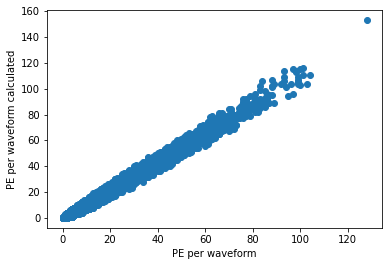

In [182]:
plt.scatter(pePerTrainWF, pePerTrainWFCalc)
plt.xlabel("PE per waveform")
plt.ylabel("PE per waveform calculated")
plt.show()

使用LightGBM，训练从以上三个feature到`pePerTrainWF`的决策树。

先创建训练集与验证集，然后存储到二进制文件中，这样可以加快训练速度，且易于代码复用。这里使用了最后50万组数据作为验证集，前面的为训练集。

In [58]:
trainDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[:-500000], pointsPerTrainWF[:-500000], pePerTrainWFCalc[:-500000]),
        axis=1
    ),
    label=pePerTrainWF[:-500000],
)
validationDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[-500000:], pointsPerTrainWF[-500000:], pePerTrainWFCalc[-500000:]),
        axis=1
    ),
    label=pePerTrainWF[-500000:],
    reference=trainDataForPePerWF,
)
trainDataForPePerWF.save_binary('./train/trainPePerWFPlay.bin')
validationDataForPePerWF.save_binary('./train/validPePerWFPlay.bin')

[LightGBM] [Warning] File ./train/trainPePerWFPlay.bin exists, cannot save binary to it
[LightGBM] [Warning] File ./train/validPePerWFPlay.bin exists, cannot save binary to it


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


开始训练决策树！最终将结果存在`modelPePerWFPlay.txt`中。

In [59]:
trainDataForPePerWF = lgb.Dataset('./train/trainPePerWFPlay.bin')
validationDataForPePerWF = lgb.Dataset('./train/validPePerWFPlay.bin', reference=trainDataForPePerWF)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForPePerWF = lgb.train(
    params,
    trainDataForPePerWF,
    num_boost_round=3000,
    valid_sets=validationDataForPePerWF,
    early_stopping_rounds=300,
)
gbmForPePerWF.save_model('modelPePerWFPlay.txt')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 1.76336
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 1.74613
[3]	valid_0's rmse: 1.72907
[4]	valid_0's rmse: 1.71219
[5]	valid_0's rmse: 1.69548
[6]	valid_0's rmse: 1.67894
[7]	valid_0's rmse: 1.66257
[8]	valid_0's rmse: 1.64638
[9]	valid_0's rmse: 1.63034
[10]	valid_0's rmse: 1.61448
[11]	valid_0's rmse: 1.59877
[12]	valid_0's rmse: 1.58323
[13]	valid_0's rmse: 1.56785
[14]	valid_0's rmse: 1.55263
[15]	valid_0's rmse: 1.53756
[16]	valid_0's rmse: 1.52265
[17]	valid_0's rmse: 1.50789
[18]	valid_0's rmse: 1.49329
[19]	valid_0's rmse: 1.47883
[20]	valid_0's rmse: 1.46453
[21]	valid_0's rmse: 1.45037
[22]	valid_0's rmse: 1.43636
[23]	valid_0's rmse: 1.4225
[24]	valid_0's rmse: 1.40878
[25]	valid_0's rmse: 1.

[263]	valid_0's rmse: 0.301226
[264]	valid_0's rmse: 0.300721
[265]	valid_0's rmse: 0.300227
[266]	valid_0's rmse: 0.299743
[267]	valid_0's rmse: 0.299265
[268]	valid_0's rmse: 0.298797
[269]	valid_0's rmse: 0.298336
[270]	valid_0's rmse: 0.297887
[271]	valid_0's rmse: 0.297447
[272]	valid_0's rmse: 0.297012
[273]	valid_0's rmse: 0.296587
[274]	valid_0's rmse: 0.296169
[275]	valid_0's rmse: 0.29576
[276]	valid_0's rmse: 0.295357
[277]	valid_0's rmse: 0.294963
[278]	valid_0's rmse: 0.294578
[279]	valid_0's rmse: 0.294198
[280]	valid_0's rmse: 0.293826
[281]	valid_0's rmse: 0.29346
[282]	valid_0's rmse: 0.293101
[283]	valid_0's rmse: 0.292752
[284]	valid_0's rmse: 0.292407
[285]	valid_0's rmse: 0.292068
[286]	valid_0's rmse: 0.291739
[287]	valid_0's rmse: 0.291413
[288]	valid_0's rmse: 0.291092
[289]	valid_0's rmse: 0.290781
[290]	valid_0's rmse: 0.290476
[291]	valid_0's rmse: 0.290174
[292]	valid_0's rmse: 0.289879
[293]	valid_0's rmse: 0.289588
[294]	valid_0's rmse: 0.289306
[295]	vali

[529]	valid_0's rmse: 0.275962
[530]	valid_0's rmse: 0.275962
[531]	valid_0's rmse: 0.275965
[532]	valid_0's rmse: 0.275964
[533]	valid_0's rmse: 0.275963
[534]	valid_0's rmse: 0.275962
[535]	valid_0's rmse: 0.275961
[536]	valid_0's rmse: 0.275961
[537]	valid_0's rmse: 0.27596
[538]	valid_0's rmse: 0.27596
[539]	valid_0's rmse: 0.27596
[540]	valid_0's rmse: 0.27596
[541]	valid_0's rmse: 0.27596
[542]	valid_0's rmse: 0.27596
[543]	valid_0's rmse: 0.275958
[544]	valid_0's rmse: 0.275958
[545]	valid_0's rmse: 0.275958
[546]	valid_0's rmse: 0.275958
[547]	valid_0's rmse: 0.275958
[548]	valid_0's rmse: 0.275958
[549]	valid_0's rmse: 0.275958
[550]	valid_0's rmse: 0.275956
[551]	valid_0's rmse: 0.275954
[552]	valid_0's rmse: 0.275953
[553]	valid_0's rmse: 0.275957
[554]	valid_0's rmse: 0.275955
[555]	valid_0's rmse: 0.275955
[556]	valid_0's rmse: 0.275959
[557]	valid_0's rmse: 0.275957
[558]	valid_0's rmse: 0.275958
[559]	valid_0's rmse: 0.275961
[560]	valid_0's rmse: 0.275963
[561]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's rmse: 0.276202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's rmse: 0.276206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's rmse: 0.276205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's rmse: 0.276209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	valid_0's rmse: 0.27621
[749]	valid_0's rmse: 0.276214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's rmse: 0.276215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	valid_0's rmse: 0.276213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's rmse: 0.276214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's rmse: 0.276214
[754]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	valid_0's rmse: 0.276254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	valid_0's rmse: 0.276258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[827]	valid_0's rmse: 0.276257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[828]	valid_0's rmse: 0.276256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	valid_0's rmse: 0.276259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's rmse: 0.276258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's rmse: 0.276261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0's rmse: 0.27626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[833]	valid_0's rmse: 0.276264
[LightGBM] [Warning] No further splits with pos

下面来观察一下决策树的预测能力。使用决策树，将全体数据输入，让其预测`pePerTrainWF`，并与真值相比较，画出散点图。

print的tuple表示三个特征在决策树中起到的作用大小。

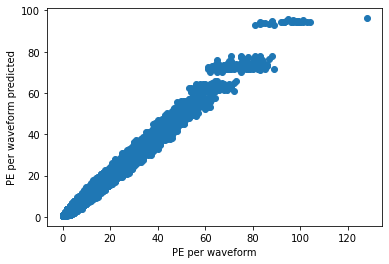

[340473 681990 177079]


In [60]:
gbmForPePerWF = lgb.Booster(model_file='./modelPePerWFPlay.txt')
pePerTrainWFFinal = gbmForPePerWF.predict(
    np.stack(
        (intTrainWF, pointsPerTrainWF, pePerTrainWFCalc),
        axis=1
    )
)
plt.scatter(pePerTrainWF, pePerTrainWFFinal)
plt.xlabel("PE per waveform")
plt.ylabel("PE per waveform predicted")
plt.show()
print(gbmForPePerWF.feature_importance())

下面开始训练第二个决策树。我们使用了五个feature：
1. 单个事件的PE总数（由第一个决策树计算得到）`peTotal`；
2. 对于单个事件，每个触发的channel都有一个PE总数，取这些的平均值`peMean`；
3. 将2中的平均值改为标准差`peStd`；
4. 对于单个事件，每个触发的channel能够用手作算法得到一个PETime平均值，取这些的平均值`peTimeMean`;
5. 将4中的平均值改为标准差`peTimeStd`

我们按照事件数，将属于不同事件的`pePerTrianWFFinal`分开，然后得到这五个feature。

In [181]:
splitPePerTrainWFFinal = np.split(pePerTrainWFCalc, wfIndices[1:-1].astype(int))
p = trainPT['p']
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1])
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)


100%|██████████| 2000/2000 [00:00<00:00, 3860.32it/s]


训练第二个决策树，并且存储到`modelPPlay.txt`

In [184]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-200], peMean[:-200], peStd[:-200], peTimeMean[:-200], peTimeStd[:-200]),
        axis=1
    ),
    label=p[:-200]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-200:], peMean[-200:], peStd[-200:], peTimeMean[-200:], peTimeStd[-200:]),
        axis=1
    ),
    label=p[-200:],
    reference=trainDataForP
)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.001,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 10,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=3000,
    valid_sets=validationDataForP,
    early_stopping_rounds=300,
    fobj=lossfunc_train,
    feval=lossfunc_eval
)
gbmForP.save_model('modelPPlay.txt')

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 6.24894	valid_0's custom: 5.44117
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 6.24273	valid_0's custom: 5.43034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.23653	valid_0's custom: 5.41953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.23033	valid_0's custom: 5.40875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 6.22414	valid_0's custom: 5.39798
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's rmse: 5.46326	valid_0's custom: 4.15706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's rmse: 5.45781	valid_0's custom: 4.14876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's rmse: 5.45237	valid_0's custom: 4.14048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's rmse: 5.44693	valid_0's custom: 4.13222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's rmse: 5.4415	valid_0's custom: 4.12397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's rmse: 5.4361	valid_0's custom: 4.11579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's rmse: 5.43067	valid_0's custom: 4.10756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's rmse: 5.07488	valid_0's custom: 3.58645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's rmse: 5.06982	valid_0's custom: 3.57929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's rmse: 5.06478	valid_0's custom: 3.57217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's rmse: 5.05974	valid_0's custom: 3.56505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's rmse: 5.05468	valid_0's custom: 3.55793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's rmse: 5.04966	valid_0's custom: 3.55085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's rmse: 5.04462	valid_0's custom: 3.54377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's rmse: 4.71431	valid_0's custom: 3.09486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's rmse: 4.70962	valid_0's custom: 3.08871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's rmse: 4.70493	valid_0's custom: 3.08257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's rmse: 4.70026	valid_0's custom: 3.07646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_0's rmse: 4.69558	valid_0's custom: 3.07033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	valid_0's rmse: 4.6909	valid_0's custom: 3.06422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	valid_0's rmse: 4.68622	valid_0's custom: 3.05811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[291]	val

[366]	valid_0's rmse: 4.34493	valid_0's custom: 2.62881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's rmse: 4.3406	valid_0's custom: 2.62358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[368]	valid_0's rmse: 4.33629	valid_0's custom: 2.61837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's rmse: 4.33197	valid_0's custom: 2.61316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's rmse: 4.32765	valid_0's custom: 2.60795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's rmse: 4.32335	valid_0's custom: 2.60278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's rmse: 4.31907	valid_0's custom: 2.59762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's rmse: 4.31479	valid_0's custom: 2.59247
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's rmse: 4.04472	valid_0's custom: 2.27804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's rmse: 4.04069	valid_0's custom: 2.27351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's rmse: 4.03669	valid_0's custom: 2.26901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's rmse: 4.03269	valid_0's custom: 2.26451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's rmse: 4.02867	valid_0's custom: 2.26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's rmse: 4.02466	valid_0's custom: 2.2555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	valid_0's rmse: 4.02064	valid_0's custom: 2.25099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[445]	valid_

[521]	valid_0's rmse: 3.72413	valid_0's custom: 1.93127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's rmse: 3.72042	valid_0's custom: 1.92742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's rmse: 3.71673	valid_0's custom: 1.9236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[524]	valid_0's rmse: 3.71303	valid_0's custom: 1.91978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[525]	valid_0's rmse: 3.70935	valid_0's custom: 1.91597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[526]	valid_0's rmse: 3.70566	valid_0's custom: 1.91217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[527]	valid_0's rmse: 3.70198	valid_0's custom: 1.90837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's rmse: 3.69829	valid_0's custom: 1.90457
[LightGBM] [Warning] No furt

[596]	valid_0's rmse: 3.45657	valid_0's custom: 1.66384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's rmse: 3.45313	valid_0's custom: 1.66053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[598]	valid_0's rmse: 3.44969	valid_0's custom: 1.65722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	valid_0's rmse: 3.44625	valid_0's custom: 1.65392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 3.44281	valid_0's custom: 1.65062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's rmse: 3.4394	valid_0's custom: 1.64735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 3.43599	valid_0's custom: 1.6441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 3.43259	valid_0's custom: 1.64084
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[668]	valid_0's rmse: 3.21787	valid_0's custom: 1.44203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's rmse: 3.21469	valid_0's custom: 1.43918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's rmse: 3.2115	valid_0's custom: 1.43632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	valid_0's rmse: 3.20831	valid_0's custom: 1.43347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's rmse: 3.20513	valid_0's custom: 1.43064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's rmse: 3.20195	valid_0's custom: 1.4278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's rmse: 3.19879	valid_0's custom: 1.42499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	vali

[740]	valid_0's rmse: 2.99631	valid_0's custom: 1.25042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's rmse: 2.99335	valid_0's custom: 1.24795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	valid_0's rmse: 2.99038	valid_0's custom: 1.24548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	valid_0's rmse: 2.98743	valid_0's custom: 1.24302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's rmse: 2.98446	valid_0's custom: 1.24056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's rmse: 2.9815	valid_0's custom: 1.2381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's rmse: 2.97854	valid_0's custom: 1.23565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's rmse: 2.9756	valid_0's custom: 1.23321
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's rmse: 2.78754	valid_0's custom: 1.08243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's rmse: 2.78478	valid_0's custom: 1.08029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's rmse: 2.78204	valid_0's custom: 1.07817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's rmse: 2.77929	valid_0's custom: 1.07604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's rmse: 2.77654	valid_0's custom: 1.07392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's rmse: 2.7738	valid_0's custom: 1.0718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's rmse: 2.77106	valid_0's custom: 1.06969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[887]	valid_0's rmse: 2.59091	valid_0's custom: 0.935293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	valid_0's rmse: 2.58835	valid_0's custom: 0.933452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[889]	valid_0's rmse: 2.58579	valid_0's custom: 0.931609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[890]	valid_0's rmse: 2.58324	valid_0's custom: 0.929771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[891]	valid_0's rmse: 2.58069	valid_0's custom: 0.92794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[892]	valid_0's rmse: 2.57814	valid_0's custom: 0.926108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[893]	valid_0's rmse: 2.57559	valid_0's custom: 0.924284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]	valid_0's rmse: 2.40582	valid_0's custom: 0.806517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[963]	valid_0's rmse: 2.40344	valid_0's custom: 0.804925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[964]	valid_0's rmse: 2.40107	valid_0's custom: 0.803335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[965]	valid_0's rmse: 2.39869	valid_0's custom: 0.801748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[966]	valid_0's rmse: 2.39632	valid_0's custom: 0.800166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[967]	valid_0's rmse: 2.39395	valid_0's custom: 0.798589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	valid_0's rmse: 2.39159	valid_0's custom: 0.797014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's rmse: 2.22279	valid_0's custom: 0.688641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1043]	valid_0's rmse: 2.22058	valid_0's custom: 0.68728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1044]	valid_0's rmse: 2.21838	valid_0's custom: 0.685918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1045]	valid_0's rmse: 2.21618	valid_0's custom: 0.684561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1046]	valid_0's rmse: 2.214	valid_0's custom: 0.683217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1047]	valid_0's rmse: 2.2118	valid_0's custom: 0.681866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1048]	valid_0's rmse: 2.20963	valid_0's custom: 0.68053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's rmse: 2.03989	valid_0's custom: 0.58025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's rmse: 2.03788	valid_0's custom: 0.579112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1131]	valid_0's rmse: 2.03588	valid_0's custom: 0.577981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1132]	valid_0's rmse: 2.03388	valid_0's custom: 0.57685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1133]	valid_0's rmse: 2.03187	valid_0's custom: 0.575714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1134]	valid_0's rmse: 2.02986	valid_0's custom: 0.574584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1135]	valid_0's rmse: 2.02787	valid_0's custom: 0.573458
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[1204]	valid_0's rmse: 1.89465	valid_0's custom: 0.500903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1205]	valid_0's rmse: 1.8928	valid_0's custom: 0.499927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1206]	valid_0's rmse: 1.89095	valid_0's custom: 0.498954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1207]	valid_0's rmse: 1.88909	valid_0's custom: 0.497982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1208]	valid_0's rmse: 1.88723	valid_0's custom: 0.497005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1209]	valid_0's rmse: 1.88538	valid_0's custom: 0.496035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1210]	valid_0's rmse: 1.88353	valid_0's custom: 0.495065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1211]	valid_0's rmse: 1.88168	valid_0's custom: 0.494098
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1270]	valid_0's rmse: 1.7756	valid_0's custom: 0.440234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1271]	valid_0's rmse: 1.77385	valid_0's custom: 0.439368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1272]	valid_0's rmse: 1.7721	valid_0's custom: 0.438507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1273]	valid_0's rmse: 1.77035	valid_0's custom: 0.437649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's rmse: 1.76861	valid_0's custom: 0.436794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	valid_0's rmse: 1.76687	valid_0's custom: 0.435942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's rmse: 1.76513	valid_0's custom: 0.435089
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1340]	valid_0's rmse: 1.65735	valid_0's custom: 0.383887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's rmse: 1.65573	valid_0's custom: 0.383137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 1.65411	valid_0's custom: 0.382393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 1.65248	valid_0's custom: 0.381645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 1.65086	valid_0's custom: 0.380902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1345]	valid_0's rmse: 1.64924	valid_0's custom: 0.380162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1346]	valid_0's rmse: 1.64762	valid_0's custom: 0.379422
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1414]	valid_0's rmse: 1.54112	valid_0's custom: 0.332319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1415]	valid_0's rmse: 1.53962	valid_0's custom: 0.331677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1416]	valid_0's rmse: 1.53811	valid_0's custom: 0.331032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1417]	valid_0's rmse: 1.5366	valid_0's custom: 0.330389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1418]	valid_0's rmse: 1.5351	valid_0's custom: 0.329751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1419]	valid_0's rmse: 1.53359	valid_0's custom: 0.329108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1420]	valid_0's rmse: 1.53208	valid_0's custom: 0.328467
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1497]	valid_0's rmse: 1.42084	valid_0's custom: 0.282917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1498]	valid_0's rmse: 1.41946	valid_0's custom: 0.282373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1499]	valid_0's rmse: 1.41806	valid_0's custom: 0.281824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's rmse: 1.41667	valid_0's custom: 0.281276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1501]	valid_0's rmse: 1.41528	valid_0's custom: 0.280732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1502]	valid_0's rmse: 1.41389	valid_0's custom: 0.28019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1503]	valid_0's rmse: 1.41251	valid_0's custom: 0.279646
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1571]	valid_0's rmse: 1.32161	valid_0's custom: 0.245224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1572]	valid_0's rmse: 1.32032	valid_0's custom: 0.244753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1573]	valid_0's rmse: 1.31905	valid_0's custom: 0.244285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1574]	valid_0's rmse: 1.31778	valid_0's custom: 0.243819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1575]	valid_0's rmse: 1.3165	valid_0's custom: 0.243352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1576]	valid_0's rmse: 1.31522	valid_0's custom: 0.242886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1577]	valid_0's rmse: 1.31395	valid_0's custom: 0.242423
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1648]	valid_0's rmse: 1.22667	valid_0's custom: 0.211698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1649]	valid_0's rmse: 1.22548	valid_0's custom: 0.211296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1650]	valid_0's rmse: 1.2243	valid_0's custom: 0.210895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1651]	valid_0's rmse: 1.22312	valid_0's custom: 0.210495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1652]	valid_0's rmse: 1.22193	valid_0's custom: 0.210093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1653]	valid_0's rmse: 1.22076	valid_0's custom: 0.209695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1654]	valid_0's rmse: 1.21957	valid_0's custom: 0.209296
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1726]	valid_0's rmse: 1.13775	valid_0's custom: 0.182601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1727]	valid_0's rmse: 1.13666	valid_0's custom: 0.182258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1728]	valid_0's rmse: 1.13557	valid_0's custom: 0.181914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1729]	valid_0's rmse: 1.13447	valid_0's custom: 0.18157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1730]	valid_0's rmse: 1.13339	valid_0's custom: 0.181228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1731]	valid_0's rmse: 1.13229	valid_0's custom: 0.180883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1732]	valid_0's rmse: 1.1312	valid_0's custom: 0.180543
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1806]	valid_0's rmse: 1.05316	valid_0's custom: 0.156981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1807]	valid_0's rmse: 1.05215	valid_0's custom: 0.156688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1808]	valid_0's rmse: 1.05113	valid_0's custom: 0.156392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1809]	valid_0's rmse: 1.05011	valid_0's custom: 0.156095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1810]	valid_0's rmse: 1.04911	valid_0's custom: 0.155805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1811]	valid_0's rmse: 1.04809	valid_0's custom: 0.15551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1812]	valid_0's rmse: 1.04709	valid_0's custom: 0.15522
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[1878]	valid_0's rmse: 0.982724	valid_0's custom: 0.137192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1879]	valid_0's rmse: 0.981784	valid_0's custom: 0.136939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1880]	valid_0's rmse: 0.980843	valid_0's custom: 0.136683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1881]	valid_0's rmse: 0.9799	valid_0's custom: 0.136429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1882]	valid_0's rmse: 0.978961	valid_0's custom: 0.136175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1883]	valid_0's rmse: 0.978021	valid_0's custom: 0.13592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1884]	valid_0's rmse: 0.977082	valid_0's custom: 0.135667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1885]	valid_0's rmse: 0.976144	valid_0's custom: 0.135414
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1945]	valid_0's rmse: 0.921663	valid_0's custom: 0.121165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1946]	valid_0's rmse: 0.920785	valid_0's custom: 0.120941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1947]	valid_0's rmse: 0.919904	valid_0's custom: 0.120719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1948]	valid_0's rmse: 0.919025	valid_0's custom: 0.120498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1949]	valid_0's rmse: 0.918149	valid_0's custom: 0.120275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1950]	valid_0's rmse: 0.91728	valid_0's custom: 0.120054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1951]	valid_0's rmse: 0.916396	valid_0's custom: 0.119832
[LightGBM] [Warning] No further splits with positive gain, best

[2021]	valid_0's rmse: 0.857193	valid_0's custom: 0.105379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2022]	valid_0's rmse: 0.856377	valid_0's custom: 0.105188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2023]	valid_0's rmse: 0.855566	valid_0's custom: 0.104996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2024]	valid_0's rmse: 0.85476	valid_0's custom: 0.104805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2025]	valid_0's rmse: 0.853946	valid_0's custom: 0.104613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2026]	valid_0's rmse: 0.853132	valid_0's custom: 0.104423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2027]	valid_0's rmse: 0.852324	valid_0's custom: 0.104233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2028]	valid_0's rmse: 0.851506	valid_0's custom: 0.104042
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2092]	valid_0's rmse: 0.801374	valid_0's custom: 0.0926478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2093]	valid_0's rmse: 0.800618	valid_0's custom: 0.0924821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2094]	valid_0's rmse: 0.799857	valid_0's custom: 0.0923144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2095]	valid_0's rmse: 0.799103	valid_0's custom: 0.0921494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2096]	valid_0's rmse: 0.798345	valid_0's custom: 0.0919841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2097]	valid_0's rmse: 0.797595	valid_0's custom: 0.0918188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2098]	valid_0's rmse: 0.796845	valid_0's custom: 0.0916552
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2163]	valid_0's rmse: 0.749675	valid_0's custom: 0.0816344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2164]	valid_0's rmse: 0.748975	valid_0's custom: 0.0814892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2165]	valid_0's rmse: 0.748274	valid_0's custom: 0.0813459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2166]	valid_0's rmse: 0.747581	valid_0's custom: 0.0812027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2167]	valid_0's rmse: 0.746884	valid_0's custom: 0.0810584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2168]	valid_0's rmse: 0.746192	valid_0's custom: 0.0809158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2169]	valid_0's rmse: 0.745496	valid_0's custom: 0.080772
[LightGBM] [Warning] No further splits with positive gai

[2223]	valid_0's rmse: 0.709107	valid_0's custom: 0.0734704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2224]	valid_0's rmse: 0.708456	valid_0's custom: 0.0733431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2225]	valid_0's rmse: 0.7078	valid_0's custom: 0.0732141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2226]	valid_0's rmse: 0.707143	valid_0's custom: 0.0730856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2227]	valid_0's rmse: 0.706488	valid_0's custom: 0.0729594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2228]	valid_0's rmse: 0.70584	valid_0's custom: 0.0728332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2229]	valid_0's rmse: 0.705188	valid_0's custom: 0.0727056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2230]	valid_0's rmse: 0.704535	valid_0's custom: 0.072577

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2299]	valid_0's rmse: 0.661273	valid_0's custom: 0.0644371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2300]	valid_0's rmse: 0.660666	valid_0's custom: 0.0643279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2301]	valid_0's rmse: 0.66006	valid_0's custom: 0.0642176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2302]	valid_0's rmse: 0.659456	valid_0's custom: 0.0641073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2303]	valid_0's rmse: 0.658854	valid_0's custom: 0.0639995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2304]	valid_0's rmse: 0.658256	valid_0's custom: 0.0638902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2305]	valid_0's rmse: 0.657652	valid_0's custom: 0.0637822
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2379]	valid_0's rmse: 0.61495	valid_0's custom: 0.0563179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2380]	valid_0's rmse: 0.614396	valid_0's custom: 0.0562256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2381]	valid_0's rmse: 0.613844	valid_0's custom: 0.0561321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2382]	valid_0's rmse: 0.613295	valid_0's custom: 0.0560388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2383]	valid_0's rmse: 0.612742	valid_0's custom: 0.0559474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2384]	valid_0's rmse: 0.61219	valid_0's custom: 0.055854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2385]	valid_0's rmse: 0.611642	valid_0's custom: 0.0557608
[LightGBM] [Warning] No further splits with positive gain,

[2456]	valid_0's rmse: 0.57397	valid_0's custom: 0.0496514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2457]	valid_0's rmse: 0.573454	valid_0's custom: 0.04957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2458]	valid_0's rmse: 0.572938	valid_0's custom: 0.0494904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2459]	valid_0's rmse: 0.572431	valid_0's custom: 0.0494108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2460]	valid_0's rmse: 0.571923	valid_0's custom: 0.0493308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2461]	valid_0's rmse: 0.571408	valid_0's custom: 0.0492502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2462]	valid_0's rmse: 0.570897	valid_0's custom: 0.0491704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2463]	valid_0's rmse: 0.570386	valid_0's custom: 0.049091

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2527]	valid_0's rmse: 0.539025	valid_0's custom: 0.0443185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2528]	valid_0's rmse: 0.538551	valid_0's custom: 0.0442502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2529]	valid_0's rmse: 0.538081	valid_0's custom: 0.0441795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2530]	valid_0's rmse: 0.537615	valid_0's custom: 0.0441106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2531]	valid_0's rmse: 0.53714	valid_0's custom: 0.0440412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2532]	valid_0's rmse: 0.536667	valid_0's custom: 0.0439713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2533]	valid_0's rmse: 0.536199	valid_0's custom: 0.0439012
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2606]	valid_0's rmse: 0.503082	valid_0's custom: 0.0391848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2607]	valid_0's rmse: 0.502651	valid_0's custom: 0.0391243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2608]	valid_0's rmse: 0.502211	valid_0's custom: 0.0390642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2609]	valid_0's rmse: 0.501778	valid_0's custom: 0.0390041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2610]	valid_0's rmse: 0.501347	valid_0's custom: 0.0389434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2611]	valid_0's rmse: 0.500908	valid_0's custom: 0.0388837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2612]	valid_0's rmse: 0.50047	valid_0's custom: 0.0388241
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2689]	valid_0's rmse: 0.468434	valid_0's custom: 0.034559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2690]	valid_0's rmse: 0.468041	valid_0's custom: 0.0345074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2691]	valid_0's rmse: 0.467643	valid_0's custom: 0.0344572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2692]	valid_0's rmse: 0.467243	valid_0's custom: 0.0344077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2693]	valid_0's rmse: 0.466854	valid_0's custom: 0.034357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2694]	valid_0's rmse: 0.466455	valid_0's custom: 0.0343069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2695]	valid_0's rmse: 0.466059	valid_0's custom: 0.0342557
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2775]	valid_0's rmse: 0.436081	valid_0's custom: 0.0305952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2776]	valid_0's rmse: 0.435727	valid_0's custom: 0.0305546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2777]	valid_0's rmse: 0.435377	valid_0's custom: 0.0305133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2778]	valid_0's rmse: 0.43502	valid_0's custom: 0.0304716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2779]	valid_0's rmse: 0.434663	valid_0's custom: 0.0304299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2780]	valid_0's rmse: 0.434309	valid_0's custom: 0.030387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2781]	valid_0's rmse: 0.433955	valid_0's custom: 0.0303457
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2857]	valid_0's rmse: 0.408098	valid_0's custom: 0.0274179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2858]	valid_0's rmse: 0.407776	valid_0's custom: 0.0273828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2859]	valid_0's rmse: 0.407448	valid_0's custom: 0.0273479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2860]	valid_0's rmse: 0.407125	valid_0's custom: 0.0273127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2861]	valid_0's rmse: 0.406797	valid_0's custom: 0.0272771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2862]	valid_0's rmse: 0.406473	valid_0's custom: 0.0272421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2863]	valid_0's rmse: 0.406148	valid_0's custom: 0.0272055
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2948]	valid_0's rmse: 0.379992	valid_0's custom: 0.0244513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2949]	valid_0's rmse: 0.379698	valid_0's custom: 0.0244225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2950]	valid_0's rmse: 0.37941	valid_0's custom: 0.024392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2951]	valid_0's rmse: 0.379117	valid_0's custom: 0.0243628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2952]	valid_0's rmse: 0.378824	valid_0's custom: 0.0243333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2953]	valid_0's rmse: 0.378536	valid_0's custom: 0.0243028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2954]	valid_0's rmse: 0.378245	valid_0's custom: 0.0242738
[LightGBM] [Warning] No further splits with positive gain

下面来观察一下决策树的预测能力。使用决策树，将全体数据输入，让其预测`p`，并与真值相比较，画出散点图。

print的tuple表示五个特征在决策树中起到的作用大小。

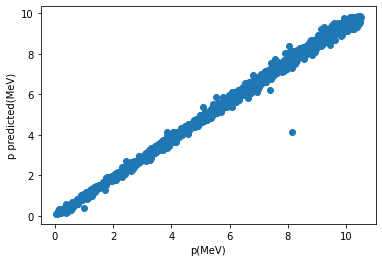

[74328 41378 27473 31108 34875]


In [185]:
plt.scatter(
    p,
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    )
)
plt.xlabel("p(MeV)")
plt.ylabel("p predicted(MeV)")
plt.show()
print(gbmForP.feature_importance())